# Setup

In [2]:
!pip install -q lightning

# ENV

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import lightning as L
from tqdm.auto import tqdm

from einops.layers.torch import Reduce, Rearrange
from einops import reduce, rearrange, repeat, einsum, parse_shape, pack, unpack

In [4]:
import seaborn as sns
sns.set()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['lines.linewidth']=2

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [5]:
L.seed_everything(42)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
device='cuda' if torch.cuda.is_available() else 'cpu'
device

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


'cuda'

# Data

In [6]:
import os
from torchvision import transforms
from torchvision.datasets import VOCSegmentation,OxfordIIITPet

class DataObject(L.LightningDataModule):
    def __init__(self, height=500, width=500, batch_size=32,):
        super().__init__()
        self.batch_size=batch_size
        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([int(height*1.1), int(width*1.1)]),
            transforms.Lambda(lambda img: (img/127.5)-1)
        ])
        self.image_size=[3,height, width]
        self.label_size=[1,height, width]

    def prepare_data(self):
        if not os.path.exists('/content/VOCdevkit'):
            VOCSegmentation('.', year='2012', download=True)

    def transforms(self, img, target):
        return self.transform(img), self.transform(target)

    def augment(self, example):
        stacked_image = torch.cat([example[0], example[1]],dim=0)
        stacked_image = transforms.RandomCrop([self.image_size[1], self.image_size[2]])(stacked_image)
        stacked_image = transforms.RandomHorizontalFlip()(stacked_image)

        return stacked_image[:3],stacked_image[3]

    def collate_fn(self, batch):
        batch=[self.augment(example) for example in batch]
        imgs=torch.stack([example[0] for example in batch],dim=0)
        target=torch.stack([example[1] for example in batch],dim=0)
        return imgs, target

    def setup(self, stage=None):
        if stage=='fit' or stage is None:
            self.train=VOCSegmentation('.', year='2012', download=False, image_set='train', transforms=self.transforms)
            self.val=VOCSegmentation('.', year='2012', download=False, image_set='trainval', transforms=self.transforms)
        if stage=='test' or stage is None:
            self.test=VOCSegmentation('.', year='2012', download=False, image_set='val', transforms=self.transforms)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True, drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, collate_fn=None, shuffle=True, drop_last=True)

tmp=DataObject()
tmp.prepare_data()
tmp.setup()
batch=next(iter(tmp.train_dataloader()))
print(len(batch))
print(batch[0].shape)
print(batch[1].shape)

2
torch.Size([32, 3, 500, 500])
torch.Size([32, 500, 500])


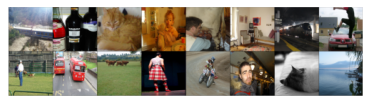

In [7]:
from torchvision.utils import make_grid

def show_image(images, num_images=16, image_size=[3,32,32]):
    images=images.detach().cpu()
    grid_image=make_grid((images[:num_images]+1)*127.5, nrow=8)
    plt.imshow(rearrange(grid_image, 'c h w -> h w c'))
    plt.axis('off')
    plt.show()

show_image(batch[0])

# Architecture 1

In [8]:
class DownSampler(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_batchnorm=True):
        super().__init__()
        self.net=nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, 2, 1, bias=False),
                               nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity(),
                               nn.LeakyReLU(0.2, inplace=True)
                               )

    def forward(self, x):
        return self.net(x)

x=torch.rand(7,3,32,32)
tmp=DownSampler(3,6,4,False)
tmp(x).shape

torch.Size([7, 6, 16, 16])

In [9]:
class UpSampler(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_dropout=True):
        super().__init__()
        self.net=nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 2, 1, bias=False),
                               nn.BatchNorm2d(out_channels),
                               nn.Dropout() if use_dropout else nn.Identity(),
                               nn.ReLU(inplace=True)
                               )

    def forward(self, x):
        return self.net(x)

x=torch.rand(7,3,32,32)
tmp=UpSampler(3,6,4,False)
tmp(x).shape

torch.Size([7, 6, 64, 64])

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_sample=nn.ModuleList([DownSampler(in_channels, 64, 4, use_batchnorm=False),
                                        DownSampler(64, 128, 4),
                                        DownSampler(128, 256, 4),
                                        DownSampler(256, 512, 4),
                                        DownSampler(512, 512, 4),
                                        DownSampler(512, 512, 4),
                                        DownSampler(512, 512, 4),
                                        DownSampler(512, 512, 4)])

        self.up_sample=nn.ModuleList([UpSampler(512, 512, 4, use_dropout=True),
                                      UpSampler(1024, 512, 4, use_dropout=True),
                                      UpSampler(1024, 512, 4, use_dropout=True),
                                      UpSampler(1024, 512, 4),
                                      UpSampler(1024, 256, 4),
                                      UpSampler(512, 128, 4),
                                      UpSampler(256, 64, 4)])

        self.head=nn.ConvTranspose2d(128, out_channels, 4, 2, 1)


    def forward(self, x):
        skips=[]
        for down in self.down_sample:
            x=down(x)
            skips.append(x)
        skips = reversed(skips[:-1])
        for up, skip in zip(self.up_sample, skips):
            x=up(x)
            x=torch.cat([x,skip], dim=1)
        x=self.head(x)

        return F.tanh(x)

x=torch.rand(7,3,256,256)
tmp=Generator(3,1)
tmp(x).shape

torch.Size([7, 1, 256, 256])

In [11]:
class Discriminator(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.net=nn.Sequential(DownSampler(in_channels, 64, 4, use_batchnorm=False),
                               DownSampler(64, 128, 4),
                               DownSampler(128, 256, 4),
                               nn.ZeroPad2d(1),
                               nn.Conv2d(256, 512, 4, stride=1, bias=False),
                               nn.BatchNorm2d(512),
                               nn.LeakyReLU(),
                               nn.ZeroPad2d(1))

        self.head = nn.Conv2d(512,1,4,stride=1)

    def forward(self, img, tar):
        x=torch.cat([img,tar],dim=1)
        x=self.net(x)
        x=self.head(x)
        return x

x=torch.rand([7,3,256,256])
tmp=Discriminator(6)
tmp(x,x).shape

torch.Size([7, 1, 30, 30])

In [12]:
# visualize model architecture

# Architecture 2

In [13]:
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, use_dropout=False, use_batchnorm=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels * 2, in_channels * 2, kernel_size=3, padding=1)
        self.batchnorm = nn.BatchNorm2d(in_channels * 2) if use_batchnorm else nn.Identity()
        self.dropout = nn.Dropout() if use_dropout else nn.Identity()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.maxpool(x)

        return x

x=torch.rand(7,3,256,256)
tmp=ContractingBlock(3)
tmp(x).shape

torch.Size([7, 6, 128, 128])

In [14]:
class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, use_dropout=False, use_batchnorm=True):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels//2, in_channels//2, kernel_size=2, padding=1)
        self.batchnorm = nn.BatchNorm2d(in_channels // 2) if use_batchnorm else nn.Identity()
        self.dropout = nn.Dropout() if use_dropout else nn.Identity()

    def forward(self, x, skip):
        x = self.upsample(x)
        x = self.conv1(x)
        skip = self.crop(skip, x.shape)
        x = torch.cat([x, skip], axis=1)

        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = F.relu(x, inplace=True)
        x = self.conv3(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = F.relu(x, inplace=True)
        return x

    def crop(self,image, new_shape):
        middle_height = image.shape[2] // 2
        middle_width = image.shape[3] // 2
        starting_height = middle_height - round(new_shape[2] / 2)
        final_height = starting_height + new_shape[2]
        starting_width = middle_width - round(new_shape[3] / 2)
        final_width = starting_width + new_shape[3]
        cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
        return cropped_image


x=torch.rand(7,8,256,256)
skip=torch.rand(7,4,512,512)
tmp=ExpandingBlock(8)
tmp(x,skip).shape

torch.Size([7, 4, 512, 512])

In [15]:
class FeatureMapBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

x=torch.rand(7,3,256,256)
tmp=FeatureMapBlock(3,3)
tmp(x).shape

torch.Size([7, 3, 256, 256])

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32):
        super().__init__()
        self.upfeature = FeatureMapBlock(in_channels, hidden_channels)

        self.contract = nn.ModuleList([ContractingBlock(hidden_channels, use_dropout=True),
                                       ContractingBlock(hidden_channels * 2, use_dropout=True),
                                       ContractingBlock(hidden_channels * 4, use_dropout=True),
                                       ContractingBlock(hidden_channels * 8),
                                       ContractingBlock(hidden_channels * 16),
                                       ContractingBlock(hidden_channels * 32)])

        self.expand = nn.ModuleList([ExpandingBlock(hidden_channels * 64),
                                     ExpandingBlock(hidden_channels * 32),
                                     ExpandingBlock(hidden_channels * 16),
                                     ExpandingBlock(hidden_channels * 8),
                                     ExpandingBlock(hidden_channels * 4),
                                     ExpandingBlock(hidden_channels * 2)])

        self.downfeature = FeatureMapBlock(hidden_channels, out_channels)

    def forward(self, x):
        skips=[]
        x = self.upfeature(x)
        skips.append(x)
        for layer in self.contract:
            x=layer(x)
            skips.append(x)
        skips=reversed(skips[:-1])

        for layer, skip in zip(self.expand, skips):
            x=layer(x, skip)

        x = self.downfeature(x)

        return F.sigmoid(x)

x=torch.rand(7,3,64,64)
tmp=UNet(3,3)
tmp(x).shape

torch.Size([7, 3, 64, 64])

In [17]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, hidden_channels=8):
        super().__init__()
        self.upfeature = FeatureMapBlock(in_channels, hidden_channels)
        self.contract=nn.Sequential(ContractingBlock(hidden_channels, use_batchnorm=False),
                               ContractingBlock(hidden_channels * 2),
                               ContractingBlock(hidden_channels * 4),
                               ContractingBlock(hidden_channels * 8))
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x = self.upfeature(x)
        x= self.contract(x)
        x = self.final(x)
        return x

x=torch.rand(7,3,64,64)
tmp=Discriminator(6)
tmp(x,x).shape

torch.Size([7, 1, 4, 4])

# Training

In [23]:
def get_gen_loss(fake_pred, fake, real, alpha=200):
    bce_loss=F.binary_cross_entropy_with_logits(fake_pred, torch.ones_like(fake_pred))
    l1_loss=reduce(abs(real-fake),'b c h w -> ()', 'mean')
    return bce_loss+alpha*l1_loss

def get_disc_loss(real_pred, fake_pred):
    real_loss=F.binary_cross_entropy_with_logits(real_pred, torch.ones_like(real_pred))
    fake_loss=F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred))
    return (real_loss+fake_loss)/2

In [24]:
lr=1e-2
batch_size=128


data_object=DataObject(256,256,batch_size)
data_object.setup()
train_loader=data_object.train_dataloader()
gen=Generator(3,1).to(device)
gen_opt=torch.optim.Adam(gen.parameters(), lr=lr)
disc=Discriminator(4).to(device)
disc_opt=torch.optim.Adam(disc.parameters(), lr=lr)

In [26]:
num_epochs=5
# 60 epoch for good result
for epoch in tqdm(range(num_epochs)):
    p_bar=tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}: ')
    for img, real in p_bar:
        img=img.to(device)
        real=real.to(device)

        disc_opt.zero_grad()
        fake=gen(img).detach()
        fake_pred=disc(img,fake)
        real_pred=disc(img,real[:,None,:,:])
        disc_loss=get_disc_loss(real_pred,fake_pred)
        disc_acc=((torch.sigmoid(real_pred)>=0.5).float().mean()+(torch.sigmoid(fake_pred)<0.5).float().mean())/2
        disc_loss.backward()
        disc_opt.step()

        gen_opt.zero_grad()
        fake=gen(img)
        fake_pred=disc(img,fake.detach())
        gen_loss=get_gen_loss(fake_pred, fake, real[:,None,:,:])
        gen_acc=(torch.sigmoid(fake_pred)>=0.5).float().mean()
        gen_loss.backward()
        gen_opt.step()

        p_bar.set_postfix(gen_loss=gen_loss.item(), disc_loss=disc_loss.item(), disc_acc=disc_acc.item(), gen_acc=gen_acc.item())

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/11 [00:00<?, ?it/s]

In [27]:
real, label=next(iter(train_loader))
real=real[:16]
label=label[:16]
fake = gen(real.to(device)).detach().cpu()
fake = torch.sigmoid(fake)
fake = (fake>=0.5).int()

real=(real+1)*127.5
label = label.unsqueeze(1)

fig, axes = plt.subplots(real.shape[0], 3, figsize=(15, real.shape[0] * 5))
for i,(r,f,l) in enumerate(zip(real, fake, label)):
    for j , img in enumerate([r,f,l]):
        axes[i,j].imshow(img.permute(1,2,0))
        axes[i,j].axis('off')

plt.tight_layout()
plt.show()